# Covid19
## Works on different public datasets

The purpose of this notebook is to provide an easy to run tool in order to have better insigts that those found in the press. Here we are going to handle with different files:
* [Instituto de Salud Carlos III](https://covid19.isciii.es/)
* [ISCIII Daily Mortality Monitoring MoMo](https://momo.isciii.es/public/momo/dashboard/momo_dashboard.html)
* [European Centre for Disease Prevention and Control](https://www.ecdc.europa.eu/en/publications-data/download-todays-data-geographic-distribution-covid-19-cases-worldwide)

### 0. Loading libraries


In [1]:
import pandas as pd
from datetime import datetime, timedelta
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, HTML

### 1. Dataset preprocessing

This section will prepare those different datasets in order to make them more easy to work with. 

#### 1.1 - ISCIII Dataset

Some considerations
* Separator: usually changes switching between ',' and ';'.
* Data is being updated via appending the new data (one record for each autonomous region) day by day, so the last records correspond with the more recent information.

In [2]:
#Spanish dataset
df = pd.read_csv("https://covid19.isciii.es/resources/serie_historica_acumulados.csv", sep=',', encoding='iso-8859-1')
df.describe()

,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
count,844.000000,436.000000,327.000000,1066.000000,1100.000000,1083.000000,1064.000000
mean,2627.286730,11129.302752,1008.009174,2916.158537,283.972727,634.341644,2404.282895
std,5228.445887,16136.569215,1201.355978,5461.833820,527.882996,1373.698876,5663.869343
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,25.000000,1852.250000,150.000000,138.250000,13.000000,7.000000,17.000000
50%,560.000000,4116.000000,561.000000,951.500000,102.000000,131.000000,432.000000
75%,2461.250000,12105.500000,1289.000000,2912.500000,299.750000,514.500000,1816.000000
max,38316.000000,62395.000000,5461.000000,40741.000000,3431.000000,8376.000000,37808.000000


In [3]:
df.columns

Index(['CCAA', 'FECHA', 'CASOS', 'PCR+', 'TestAc+', 'Hospitalizados', 'UCI',
       'Fallecidos', 'Recuperados'],
      dtype='object')

#### Dataset information

* ```CCAA```: region code
* ```FECHA```: date of the record
* ```CASOS```: new infections detected (mainly empty)
* ```PCR+```: referring to the ```CASOS``` means the new infections detected via a positive [PCR test](https://en.wikipedia.org/wiki/Polymerase_chain_reaction)
* ```TestAc+```: Similar to the ```PCR+```. Quick test focused on Antibodies
* ```Hospitalizados```: hospitalized people related with Covid-19
* ```UCI```: hospitalized people who require Intensive Care Units
* ```Fallecidos```: deceased people
* ```Recuperados```: recovered people

Let's have a look at their content. 

In [4]:
df.head()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,20/2/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AR,20/2/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS,20/2/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IB,20/2/2020,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,CN,20/2/2020,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.tail()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
1407,Los datos de estas comunidades son datos de pr...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1408,* Desde el día 11/04/2020 las cifras de hospit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1409,* Desde el día 12/04/2020 las cifras de UCIs d...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1410,* Desde el día 26/04/2020 las cifras de Hospit...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1411,NOTA2:Se excluyen de la serie las notificacion...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
df['CCAA'].unique()

array(['AN', 'AR', 'AS', 'IB', 'CN', 'CB', 'CM', 'CL', 'CT', 'CE', 'VC',
       'EX', 'GA', 'MD', 'ML', 'MC', 'NC', 'PV', 'RI',
       'NOTA: El objetivo de los datos que se publican en esta web es saber el número de casos acumulados a la fecha y que por tanto no se puede deducir que la diferencia entre un día y el anterior es el número de casos nuevos ya que esos casos pueden haber sido recuperados de fechas anteriores. Cualquier inferencia que se haga sobre las diferencias de un día para otro deben hacerse con precaución y son únicamente la responsabilidad del autor.',
       'Los datos de estas comunidades son datos de prevalencia (personas ingresadas a fecha de hoy). No reflejan el total de personas que han sido hospitalizadas o ingresadas en UCI\xa0 a lo largo del periodo de notificación(CL(UCIs)-GA(UCIS)-CM*-MD**)',
       '* Desde el día 11/04/2020 las cifras de hospitalizados de CM son casos acumulados. Previamente se refieren a personas ingresadas ese día.',
       '* Desde el

#### Conclusions up to here

There are plenty of missing information and also a lot of noise in the data. Data is not properly indexed by date. In fact, data is being updated via appending the new data (one record for each region) day by day, so the last records correspond with the more recent information. The idea is to correct this problems and reconstruct the whole time series. Let's handle this. 

First of all, identify the region code in order to filter. 

In [7]:
region = ['AN', 'AR', 'AS', 'IB', 'CN',
         'CB', 'CM', 'CL', 'CT', 'CE',
         'VC', 'EX', 'GA', 'MD', 'ML',
         'MC', 'NC', 'PV', 'RI']


In [8]:
# Filter record based on valid region
df = df[df['CCAA'].isin(region)]

In [9]:
df.head()

,CCAA,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados
0,AN,20/2/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AR,20/2/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,AS,20/2/2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,IB,20/2/2020,1.0,NaN,NaN,NaN,NaN,NaN,NaN
4,CN,20/2/2020,1.0,NaN,NaN,NaN,NaN,NaN,NaN


#### Reconstruct time series

In this step we're going to fix some issues in data:
* Fill ```CASOS``` column. This could be calculated based on the difference between ```PCR+``` day by day
* Reconstruct the time series. At the moment, the features reflect the snapshot of the day by day, but there are no features representing the increments between dates. For this pupose, the reconstruction of the time series consist on calculate those increments on new features. In this manner, the following features will reflect the variation for those data respect the day before:
    * ```IncHospitalizados```
    * ```IncUCI```
    * ```IncFallecidos```
    * ```IncRescuperados```

In [20]:
def rebuildSeries(df, ndays):
    """
    df: Pandas DataFrame:  dataframe to reconstruct
    ndays: Integer: how many days to calculate backwards
    return: DataFrame reconstructed with new features
    """
    cols = ['FECHA', 'CCAA', 'CASOS', 'PCR+', 'TestAc+', 'Hospitalizados',
            'UCI', 'Fallecidos', 'Recuperados']
    rebuilt = list()
    for i in range(1,ndays + 1):
        limit = -(i-1)*len(region)
        if limit != 0:
            today = df.iloc[-i*len(region):limit]
        else:
            today = df.iloc[-i*len(region):]
        today = today.sort_values('CCAA')
        today['FECHA'] = (datetime.now() - timedelta(days=i-1)).strftime("%Y-%m-%d") 
        yesterday = df.iloc[-(i+1) *len(region):-i*len(region)].sort_values('CCAA')
        assert today.shape == yesterday.shape, "Shapes do not fit [{}] {} vs {}".format(i, 
                                                                                        today.shape,
                                                                                        yesterday.shape)
        today['CASOS'] = (today['PCR+'].reset_index() - yesterday['PCR+'].reset_index())['PCR+'].to_numpy()
        today = today[cols]
        for item in ['Hospitalizados', 'UCI', 'Fallecidos', 'Recuperados']:
            today['Inc' + item] = (today[item].reset_index() -
                                   yesterday[item].reset_index())[item].to_numpy()
        today.reset_index()
        rebuilt.append(today)
    rebuilt.reverse()
    return pd.concat(rebuilt, ignore_index=True)

#### Rebuild 30 days backwards

In [24]:
res = rebuildSeries(df, 30)

In [25]:
res.tail(20)

,FECHA,CCAA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados,IncHospitalizados,IncUCI,IncFallecidos,IncRecuperados
550,2020-05-03,VC,25.0,10436.0,2250.0,5181.0,698.0,1264.0,7447.0,28.0,3.0,6.0,160.0
551,2020-05-04,AN,19.0,12194.0,2155.0,5973.0,738.0,1263.0,7021.0,12.0,2.0,7.0,124.0
552,2020-05-04,AR,24.0,5188.0,1051.0,2526.0,260.0,762.0,2624.0,7.0,0.0,1.0,66.0
553,2020-05-04,AS,1.0,2306.0,685.0,2014.0,142.0,284.0,917.0,19.0,0.0,4.0,9.0
554,2020-05-04,CB,1.0,2206.0,390.0,1011.0,79.0,197.0,1610.0,1.0,0.0,2.0,-6.0
555,2020-05-04,CE,0.0,101.0,51.0,10.0,4.0,4.0,142.0,0.0,0.0,0.0,1.0
556,2020-05-04,CL,51.0,17334.0,4045.0,8123.0,534.0,1818.0,6900.0,38.0,1.0,18.0,44.0
557,2020-05-04,CM,33.0,16050.0,5461.0,8698.0,606.0,2590.0,5794.0,22.0,2.0,25.0,22.0
558,2020-05-04,CN,4.0,2225.0,0.0,919.0,175.0,141.0,1166.0,0.0,0.0,1.0,16.0
559,2020-05-04,CT,132.0,50366.0,1027.0,27321.0,2847.0,5220.0,21898.0,64.0,3.0,35.0,1566.0


In [26]:
res[res['CCAA']=='CM'].tail()

,FECHA,CCAA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados,IncHospitalizados,IncUCI,IncFallecidos,IncRecuperados
481,2020-04-30,CM,47.0,15832.0,4239.0,8567.0,592.0,2463.0,5512.0,44.0,4.0,27.0,130.0
500,2020-05-01,CM,78.0,15910.0,4606.0,8618.0,596.0,2498.0,5615.0,51.0,4.0,35.0,103.0
519,2020-05-02,CM,57.0,15967.0,5056.0,8645.0,601.0,2534.0,5702.0,27.0,5.0,36.0,87.0
538,2020-05-03,CM,50.0,16017.0,5273.0,8676.0,604.0,2565.0,5772.0,31.0,3.0,31.0,70.0
557,2020-05-04,CM,33.0,16050.0,5461.0,8698.0,606.0,2590.0,5794.0,22.0,2.0,25.0,22.0


### 2. Functions to explore data

Now we have our data well formatted, is time to explore. For this purpose, several functions are created to easy filter and plot the DataFrame. Interactive plots coming soon :D 

In [27]:
def displayInfo(df, location=None, date=None):
    """
    location: string: region code
    date: string: date to query format YYYY-MM-DD
    return: dataframe display
    """
    if date == 'today':
        date = datetime.now().strftime("%Y-%m-%d") 
    elif date != None:
        df = df[df['FECHA']== date]
    if location:
        df = df[df['CCAA']==location]
    else:
        df = df.groupby(['FECHA']).sum().reset_index()
    return display(df)
    
def showStats(df, location=None, from_date='2020-03-01', to_date=None, feature='IncFallecidos'):
    """
    df: Pandas DataFrame
    location: string: region code
    from_date: string: date to start the time window query. Format YYYY-MM-DD
    to_date: string: end of the time window query. Format YYYY-MM-DD
    "feature": string: feature to plot
    return: None (plot info)
    """
    if location:
        df = df[df.CCAA==location]

    df = df[df.FECHA >= from_date]
    
    if to_date:
        df = df[df.FECHA >= to_date]

    dates = list(df.FECHA.unique())
    dates.sort(reverse=False)
    
    pal = sns.cubehelix_palette(len(df))
    rank = df[feature].argsort().argsort()   # http://stackoverflow.com/a/6266510/1628638
    if not location:
        df = df.groupby(['FECHA']).sum().reset_index()

    fig, ax = plt.subplots(1,1, figsize=(16,10))
    sns.barplot(data=df,
                x='FECHA',
                y=feature,
                label=feature,
                palette=np.array(pal[::1])[rank],
                color='lightblue',
#                hue='CCAA',
                order=dates,
                ax=ax)

    plt.xticks(rotation=90)
    plt.title("Evolution {} since {} of {}".format(location or "", from_date, feature, from_date))
    plt.legend()
    plt.show()

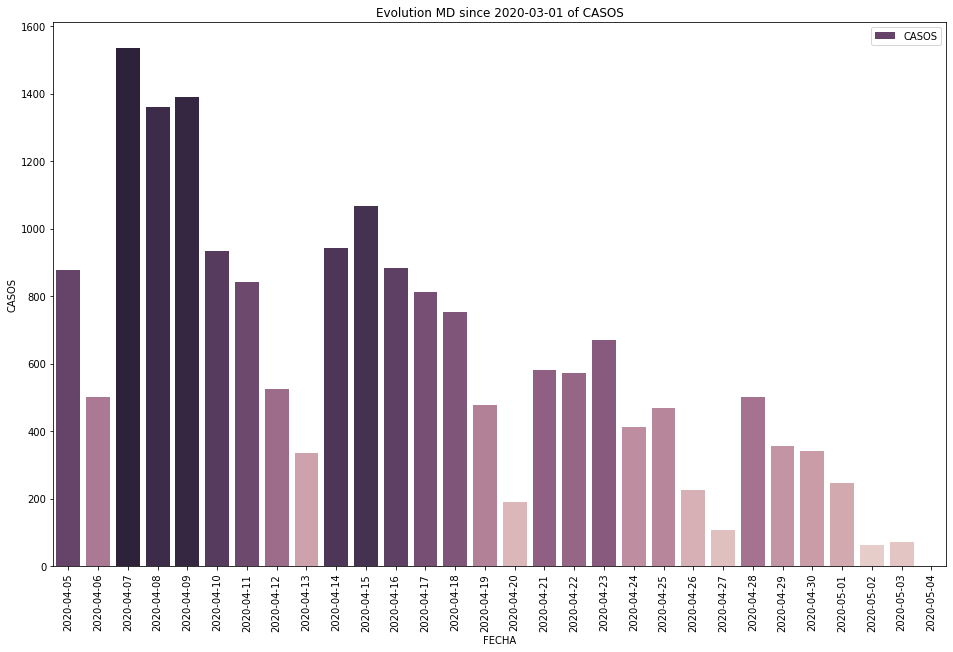

In [28]:
showStats(res, location='MD', feature='CASOS')

In [29]:
displayInfo(res)

,FECHA,CASOS,PCR+,TestAc+,Hospitalizados,UCI,Fallecidos,Recuperados,IncHospitalizados,IncUCI,IncFallecidos,IncRecuperados
0,2020-04-05,1310.0,53517.0,0.0,58936.0,6362.0,11834.0,33701.0,1147.0,285.0,670.0,3528.0
1,2020-04-06,781.0,54298.0,0.0,60069.0,6443.0,12462.0,35723.0,1133.0,81.0,628.0,2022.0
2,2020-04-07,1718.0,56016.0,0.0,60802.0,6526.0,13219.0,38620.0,733.0,83.0,757.0,2897.0
3,2020-04-08,1589.0,57605.0,0.0,61500.0,6644.0,13976.0,43091.0,698.0,118.0,757.0,4471.0
4,2020-04-09,1650.0,59255.0,0.0,62606.0,6810.0,14757.0,47116.0,1106.0,166.0,781.0,4025.0
5,2020-04-10,1181.0,60436.0,0.0,63822.0,6866.0,15399.0,50860.0,1216.0,56.0,642.0,3744.0
6,2020-04-11,1042.0,61478.0,0.0,64323.0,6895.0,15899.0,54118.0,501.0,29.0,500.0,3258.0
7,2020-04-12,820.0,62298.0,0.0,69868.0,6914.0,16505.0,57026.0,5545.0,19.0,606.0,2908.0
8,2020-04-13,422.0,62720.0,0.0,71412.0,7147.0,17056.0,59165.0,1544.0,233.0,551.0,2139.0
9,2020-04-14,1051.0,63771.0,0.0,71850.0,7177.0,17591.0,61924.0,438.0,30.0,535.0,2759.0
